<a href="https://colab.research.google.com/github/MALLI7622/Brain-Decoding/blob/main/Brain_Decoding_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fMRI_response_path = "/content/drive/MyDrive/Brain_Decoding_Data/EstimatedResponses.mat"
Images_path = "/content/drive/MyDrive/Brain_Decoding_Data/Stimuli.mat"

In [ ]:
import numpy as np
import h5py
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [ ]:
stim = h5py.File(fMRI_response_path, "r")

try:
    resp = h5py.File(Images_path, "r")
except:
    resp = loadmat(Images_path)

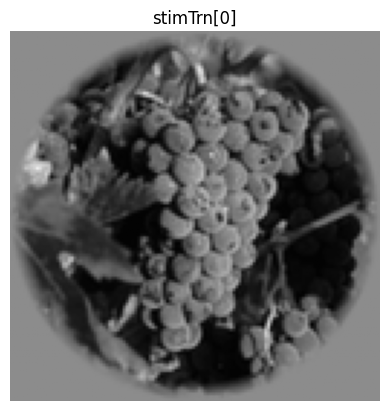

In [ ]:
idx = np.random.randint(0, resp['stimTrn'].shape[0])
plt.imshow(resp['stimTrn'][idx], cmap='gray', vmin=-0.55, vmax=0.45)
plt.axis('off')
plt.title("stimTrn[0]")
plt.show()

In [ ]:
clip_features_train = np.load("/content/drive/MyDrive/Brain_Decoding_Data/clip_features_natural_images.npy")
clip_features_val = np.load("/content/drive/MyDrive/Brain_Decoding_Data/clip_features_natural_images_val.npy")
print(clip_features_train.shape, clip_features_val.shape)

(1750, 768) (120, 768)


In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
from scipy.io import loadmat
import numpy as np
from transformers import CLIPProcessor, CLIPModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py

import torch
import torch.nn as nn

import torch
import torchvision.transforms as T
from PIL import Image
from scipy.io import loadmat
import numpy as np
from transformers import CLIPProcessor, CLIPModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py


import numpy as np
import h5py
from scipy.io import loadmat
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm

In [ ]:
class FMRIDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


class FMRIClipDataset(Dataset):
    def __init__(self, fmri_data, clip_embeddings, clip_mean=None, clip_std=None, normalize=True):
        self.fmri = torch.tensor(fmri_data, dtype=torch.float32)
        self.normalize = normalize

        if normalize:
            if clip_mean is None or clip_std is None:
                clip_mean = clip_embeddings.mean(axis=0)
                clip_std = clip_embeddings.std(axis=0)
            self.clip_mean = clip_mean
            self.clip_std = clip_std
            clip_embeddings = (clip_embeddings - clip_mean) / clip_std

        self.clip = torch.tensor(clip_embeddings, dtype=torch.float32)

    def __len__(self):
        return len(self.fmri)

    def __getitem__(self, idx):
        return self.fmri[idx], self.clip[idx]


In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
train_labels = np.load("/content/drive/MyDrive/Brain_Decoding_Data/train_labels.npy")
clip_preds_train = np.load("/content/drive/MyDrive/Brain_Decoding_Data/clip_preds_train.npy")

In [ ]:
train_labels.shape, clip_preds_train.shape

((3500, 128, 128), (3500, 768))

In [ ]:
import torch
from torch.utils.data import Dataset

class DiffusionDataset(Dataset):
    def __init__(self, clip_embeddings, images):
        self.clip_embeddings = torch.tensor(clip_embeddings, dtype=torch.float32)
        self.images = torch.tensor(images, dtype=torch.float32).unsqueeze(1)  # [N, 1, 128, 128]

    def __len__(self):
        return len(self.clip_embeddings)

    def __getitem__(self, idx):
        clip_emb = self.clip_embeddings[idx]            # [768]
        image = self.images[idx]                        # [1, 128, 128]
        image = (image - 0.5) * 2                       # ✅ Scale image from [0,1] to [-1,1]
        return image, clip_emb



class NoiseScheduler:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.timesteps = timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def get_params(self, t):
        return self.alpha_bars[t], self.betas[t]


In [ ]:
train_dataset = DiffusionDataset(clip_preds_train, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [ ]:
len(train_dataset)

3500

In [ ]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([1, 128, 128]), torch.Size([768]))

In [ ]:
def get_timestep_embedding(timesteps, embedding_dim):
    device = timesteps.device
    half_dim = embedding_dim // 2
    emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb  # shape [B, embedding_dim]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, cond_dim, num_groups=8):
        super().__init__()
        self.norm1 = nn.GroupNorm(num_groups=min(4, in_channels), num_channels=in_channels)
        self.norm2 = nn.GroupNorm(num_groups=min(4, out_channels), num_channels=out_channels)
        self.activation = nn.GELU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.film_mlp = nn.Sequential(
            nn.Linear(cond_dim, out_channels * 2),
            nn.GELU(),
            nn.Dropout(0.1)
        )

        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t_emb, cond_emb):
        h = self.activation(self.norm1(x))
        h = self.conv1(h)

        t = self.time_mlp(t_emb).view(x.size(0), -1, 1, 1)
        gamma_beta = self.film_mlp(cond_emb).view(x.size(0), -1, 1, 1)
        gamma, beta = torch.chunk(gamma_beta, 2, dim=1)

        h = gamma * h + beta + t  # FiLM + time injection

        h = self.activation(self.norm2(h))
        h = self.conv2(h)

        return h + self.residual_conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, cond_dim):
        super().__init__()
        self.res = ResidualBlock(in_ch, out_ch, time_emb_dim, cond_dim)
        self.down = nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)

    def forward(self, x, t, c):
        x = self.res(x, t, c)
        return self.down(x), x  # return downsampled and skip

class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, time_emb_dim, cond_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.res = ResidualBlock(out_ch + skip_ch, out_ch, time_emb_dim, cond_dim)

    def forward(self, x, skip, t, c):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.res(x, t, c)

class ConditionedUNetWithSkips(nn.Module):
    def __init__(self, cond_dim=768, time_emb_dim=256, in_channels=1, base_channels=64):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.GELU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        self.init_cond_proj = nn.Conv2d(cond_dim, 1, kernel_size=1)  # for spatial conditioning injection

        self.down1 = DownBlock(in_channels + 1, base_channels, time_emb_dim, cond_dim)           # 1+1 → 128
        self.down2 = DownBlock(base_channels, base_channels * 2, time_emb_dim, cond_dim)      # 128 → 256
        self.down3 = DownBlock(base_channels * 2, base_channels * 4, time_emb_dim, cond_dim)  # 256 → 512
        self.down4 = DownBlock(base_channels * 4, base_channels * 8, time_emb_dim, cond_dim)  # 512 → 1024

        # Bottleneck
        self.bot = ResidualBlock(base_channels * 8, base_channels * 8, time_emb_dim, cond_dim)

        # Up path
        self.up4 = UpBlock(base_channels * 8, base_channels * 8, base_channels * 4, time_emb_dim, cond_dim)
        self.up3 = UpBlock(base_channels * 4, base_channels * 4, base_channels * 2, time_emb_dim, cond_dim)
        self.up2 = UpBlock(base_channels * 2, base_channels * 2, base_channels, time_emb_dim, cond_dim)
        self.up1 = UpBlock(base_channels, base_channels, base_channels, time_emb_dim, cond_dim)

        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(base_channels, 1, kernel_size=1),
            nn.Tanh()
        )

    def forward(self, x, t, cond):
        # Spatial broadcast + projection of cond vector
        cond_map = cond.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, x.shape[2], x.shape[3])  # [B, 768, H, W]
        cond_proj = self.init_cond_proj(cond_map)  # [B, 1, H, W]
        x = torch.cat([x, cond_proj], dim=1)  # [B, 2, H, W]

        t_embed = get_timestep_embedding(t, self.time_emb_dim)
        t_emb = self.time_mlp(t_embed)

        d1, skip1 = self.down1(x, t_emb, cond)
        d2, skip2 = self.down2(d1, t_emb, cond)
        d3, skip3 = self.down3(d2, t_emb, cond)
        d4, skip4 = self.down4(d3, t_emb, cond)

        b = self.bot(d4, t_emb, cond)

        u4 = self.up4(b, skip4, t_emb, cond)
        u3 = self.up3(u4, skip3, t_emb, cond)
        u2 = self.up2(u3, skip2, t_emb, cond)
        u1 = self.up1(u2, skip1, t_emb, cond)

        return self.final(u1)


In [ ]:
# def preprocess_for_clip(img_tensor):
#     # img_tensor: [B, 1, H, W] → make it [B, 3, 224, 224]
#     img_tensor = F.interpolate(img_tensor, size=(224, 224), mode='bilinear', align_corners=False)
#     img_tensor = img_tensor.repeat(1, 3, 1, 1)  # grayscale → RGB
#     return img_tensor

def preprocess_for_clip(img):
    img = F.interpolate(img, (224,224), mode='bilinear', align_corners=False)
    img = (img + 1) / 2
    img = img.repeat(1,3,1,1)
    mean = torch.tensor([0.48145466,0.4578275,0.40821073], device=img.device).view(1,3,1,1)
    std  = torch.tensor([0.26862954,0.26130258,0.27577711], device=img.device).view(1,3,1,1)
    return (img - mean) / std

In [ ]:
# 1. Instantiate model
model = ConditionedUNetWithSkips(
    cond_dim=768,        # your CLIP embedding size
    time_emb_dim=256,
    in_channels=1,       # grayscale input
    base_channels=128
)

# 2. Noise scheduler (you should define alpha_bars inside it)
scheduler = NoiseScheduler(timesteps=1000)

# 3. Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


tensor(0.)

In [ ]:
# model.load_state_dict(torch.load("/content/drive/MyDrive/Brain_Decoding_Data/best_model_brain_decoding_v4_2.pt"))

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
# ✅ Step 1: Enhanced Conditioning via FiLM + Concatenation already exists in your architecture.
# You use: cond_mlp + dropout injection (FiLM-style) → Good.
# To strengthen it further, let's apply early concatenation at input as well.

# Below is a training loop with:
# - cosine conditioning loss
# - weighted sum loss
# - early stopping
# - model saving
# - embedding alignment tracking

import torch
import torch.nn.functional as F
from torchvision.utils import save_image
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt


def cosine_loss(a, b):
    a_norm = F.normalize(a, dim=-1)
    b_norm = F.normalize(b, dim=-1)
    return 1 - (a_norm * b_norm).sum(dim=-1).mean()


def train_loop(
    model, dataloader, optimizer, scheduler, clip_model,
    lambda_cond = 1, device='cuda',
    max_epochs=50, early_stop_patience=5, save_path='best_model.pt'
):
    model = model.to(device)
    clip_model = clip_model.to(device).eval()

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(max_epochs):
        model.train()
        total_loss, total_diff, total_cond = 0, 0, 0
        batch_idx = 0
        for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]
            clip_cond = F.normalize(clip_cond, dim=-1)
            clip_cond = F.normalize(clip_cond + 0.01*torch.randn_like(clip_cond), dim=-1)
            x_0, clip_cond = x_0.to(device), clip_cond.to(device)
            B = x_0.size(0)
            t = torch.randint(0, scheduler.timesteps, (B,), device=device)
            # alpha_bar = scheduler.alpha_bars[t].view(B, 1, 1, 1).to(device)
            alpha_bar = scheduler.alpha_bars.to(t.device)[t].view(B, 1, 1, 1)

            noise = torch.randn_like(x_0)
            x_t = (alpha_bar.sqrt() * x_0 + (1 - alpha_bar).sqrt() * noise)

            # pred_noise = model(x_t, t.float() / scheduler.timesteps, clip_cond)
            pred_noise = model(x_t, t, clip_cond)
            loss_diff = F.mse_loss(pred_noise, noise)

            with torch.no_grad():
                x_0_pred = (x_t - (1 - alpha_bar).sqrt() * pred_noise) / alpha_bar.sqrt()
                x_0_pred = torch.clamp(x_0_pred, -1, 1)
                x_0_clip = preprocess_for_clip(x_0)
                x_0_pred_clip = preprocess_for_clip(x_0_pred)

                if batch_idx == 0:  # only do for first batch
                    x_0_clip = preprocess_for_clip(x_0)
                    x_0_pred_clip = preprocess_for_clip(x_0_pred)
                    plot_embedding_similarity(x_0_clip, x_0_pred_clip, clip_model)

                gt_embed = clip_model.get_image_features(x_0_clip)
                pred_embed = clip_model.get_image_features(x_0_pred_clip)

            loss_cond = cosine_loss(pred_embed, gt_embed)

            loss = loss_diff + lambda_cond * loss_cond

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_idx += 1

            total_loss += loss.item()
            total_diff += loss_diff.item()
            total_cond += loss_cond.item()

        avg_loss = total_loss / len(dataloader)
        avg_diff = total_diff / len(dataloader)
        avg_cond = total_cond / len(dataloader)

        print(f"Epoch {epoch+1}: Total={avg_loss:.4f}, Diff={avg_diff:.4f}, Cond={avg_cond:.4f}")

        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            patience_counter = 0
            print("✅ Saving new best model")
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("⏹️ Early stopping triggered")
                break


def plot_embedding_similarity(gt_imgs, gen_imgs, clip_model):
    with torch.no_grad():
        gt_embed = clip_model.get_image_features(gt_imgs)
        gen_embed = clip_model.get_image_features(gen_imgs)
        sim_matrix = cosine_similarity(gt_embed.cpu(), gen_embed.cpu())
        avg_sim = np.mean(np.diag(sim_matrix))

        print("Average Cosine Similarity:", avg_sim)

        # # 🔥 Plot the similarity heatmap
        # plt.figure(figsize=(12, 8))
        # sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap='viridis',
        #             xticklabels=[f"gen_{i}" for i in range(len(gen_imgs))],
        #             yticklabels=[f"gt_{i}" for i in range(len(gt_imgs))])
        # plt.title(f"Embedding Cosine Similarity (avg: {avg_sim:.2f})")
        # plt.xlabel("Generated Images")
        # plt.ylabel("Ground Truth Images")
        # plt.tight_layout()
        # plt.show()

        return sim_matrix

In [ ]:
clip_model  = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [ ]:
train_loop(model, train_dataloader, optimizer, scheduler, clip_model)

/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.71112204
Epoch 1: Total=0.5294, Diff=0.2372, Cond=0.2923
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.6976085
Epoch 2: Total=0.4776, Diff=0.1906, Cond=0.2870
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.7301895
Epoch 3: Total=0.4633, Diff=0.1859, Cond=0.2775
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.71884304
Epoch 4: Total=0.4582, Diff=0.1819, Cond=0.2763
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.73410875
Epoch 5: Total=0.4538, Diff=0.1802, Cond=0.2736
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.73329955
Epoch 6: Total=0.4511, Diff=0.1780, Cond=0.2731
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.732612
Epoch 7: Total=0.4504, Diff=0.1770, Cond=0.2734
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.7107253
Epoch 8: Total=0.4508, Diff=0.1797, Cond=0.2711


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.7204547
Epoch 9: Total=0.4456, Diff=0.1745, Cond=0.2710
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.71033275


KeyboardInterrupt: 

In [ ]:
import torch
import matplotlib.pyplot as plt

def debug_infer_and_plot(unet_model, image_tensor, cond_vector, noise_scheduler, device='cuda'):
    model = unet_model.to(device)
    model.eval()

    x_0 = image_tensor.unsqueeze(0).to(device)  # [1, 1, 128, 128]
    cond = cond_vector.unsqueeze(0).to(device)  # [1, 768]

    t = torch.randint(0, noise_scheduler.timesteps + 1, (1,), device=device)
    alpha_bar = noise_scheduler.alpha_bars.to(device)[t].view(1, 1, 1, 1)

    noise = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise

    with torch.no_grad():
        pred_noise = model(x_t, t, cond)
        x_0_pred = (x_t - torch.sqrt(1 - alpha_bar) * pred_noise) / torch.sqrt(alpha_bar)
        x_0_pred = (x_0_pred.clamp(-1, 1) + 1) / 2
        x_0_gt = (x_0.clamp(-1, 1) + 1) / 2

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(x_0_gt[0, 0].cpu().numpy(), cmap='gray')
    axes[0].set_title("Ground Truth")
    axes[0].axis('off')

    axes[1].imshow(x_0_pred[0, 0].cpu().numpy(), cmap='gray')
    axes[1].set_title("Generated")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
clip_features_val.shape

(120, 768)

In [ ]:
val_labels = np.concatenate([resp['stimVal'][:], resp['stimVal']])
val_labels.shape

(240, 128, 128)

In [ ]:
clip_features_val = np.concatenate([clip_features_val, clip_features_val])
clip_features_val.shape

(240, 768)

In [ ]:
import random

torch.Size([768]) torch.Size([1, 128, 128])


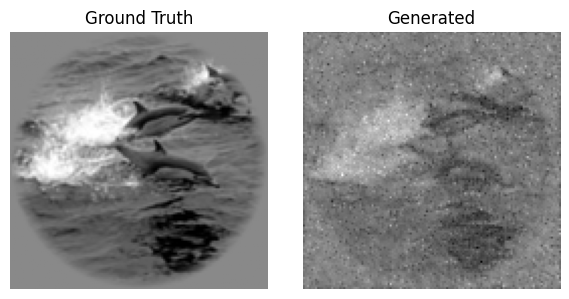

In [ ]:
# # Suppose your image and conditioning vector are as follows
# # Make sure they are torch tensors
# sample_clip = torch.tensor(clip_preds_train[:4])       # [4, 768]
# sample_gt = torch.tensor(train_labels[:4]).unsqueeze(1)  # [4, 1, 128, 128]

# Ensure it's a float32 torch tensor of shape [1, 128, 128]

# idx = random.randint(0, len(val_labels))
# single_image = torch.tensor(val_labels[idx], dtype=torch.float32).unsqueeze(0)  # shape [1, 128, 128]
# single_cond = torch.tensor(clip_features_val[idx], dtype=torch.float32)        # shape [768]

idx = random.randint(0, len(train_labels))
single_image = torch.tensor(train_labels[idx], dtype=torch.float32).unsqueeze(0)  # shape [1, 128, 128]
single_cond = torch.tensor(clip_preds_train[idx], dtype=torch.float32)        # shape [768]

print(single_cond.shape, single_image.shape)

# Call the debug function
debug_infer_and_plot(
    unet_model=model,
    image_tensor=single_image,
    cond_vector=single_cond,
    noise_scheduler=scheduler,
    device='cuda'  # or 'cpu' if not using GPU
)


In [ ]:
torch.cuda.empty_cache()

In [ ]:
save_path = "/content/drive/MyDrive/Brain_Decoding_Data/best_model_brain_decoding_v4_3.pt"
torch.save(model.state_dict(), save_path)